<a href="https://colab.research.google.com/github/Ruanvans/GAN-time-series-implementation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following code will serve as the GAN network employed in my disseratation**

**Ruan van Schalkwyk**                                                            
**6459265**

**Supervisor: Yoachu Jin** 

**University of Surrey Computer Science** 


# **Necessary libraries and tools**

In [11]:
%pip install keras-tcn

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=2b14ec3916d9fc347cb306c73ff02879afc23a8354c8179643b2045dada79507
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [1]:
#libraries and tools necessary to import and visualize data
from google.colab import files
import pandas as pd
import requests 
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot

#libraries to create the models and visualize models
from keras.models import Sequential 
from keras.layers import Dense 
from keras.utils.vis_utils import plot_model
import numpy as np
from numpy import hstack 
from numpy import zeros 
from numpy import ones 
from numpy.random import randn 
from numpy.random import rand
import random
#from tcn import TCN, tcn_full_summary

Using TensorFlow backend.


# **Data Collection**

The below cells of code are used to retrieve the data used within the project from the AlphaVantage API. The first cell works directly with the API and the second cell is used to format the data into the correct format (csv file) and then downloads the data so that it can be cleaned for further use

In [0]:
Key = 'WS42XHAOBGP40QEM'
sym= 'AAPL'

fname = 'daily' + sym +'.csv'

if not os.path.isfile(fname):
  v = urllib.request.urlopen("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=" + sym + "&apikey=" + Key + "&outputsize=full&datatype=csv").read()
  with open(fname, 'wb') as f:
    f.write(v)

In [0]:
df = pd.read_csv(fname)
df = pd.DataFrame(df)
df.to_csv('Apple.csv')
files.download('Apple.csv')
df

,timestamp,open,high,low,close,volume
0,2020-05-11,308.10,317.05,307.24,315.01,36486561
1,2020-05-08,305.64,310.35,304.29,310.13,33511985
2,2020-05-07,303.22,305.17,301.97,303.74,28803764
3,2020-05-06,300.46,303.24,298.87,300.63,35583438
4,2020-05-05,295.06,301.00,294.46,297.56,36937795
...,...,...,...,...,...,...
5027,2000-05-16,104.52,109.06,102.75,105.69,3932600
5028,2000-05-15,108.06,108.06,100.12,101.00,6061900
5029,2000-05-12,106.00,110.50,104.77,107.62,2740300
5030,2000-05-11,101.37,104.25,99.00,102.81,4462000


# **Data preprocessign**

Below cell provides convenience when uploading the data as it is faster to upload a zip file with all the cleaned data to google colab than to upload individual files. 

In [0]:
!unzip 'final_data.zip'

Archive:  final_data.zip
  inflating: boeing.csv              
  inflating: Intercontinental.csv    
  inflating: JPMorgan.csv            
  inflating: Microsoft.csv           
  inflating: pfizer.csv              


importation of the data from the cleaned csv files

In [0]:
intercontinental = pd.read_csv('Intercontinental.csv', parse_dates=True, index_col=0)
boeing = pd.read_csv('boeing.csv', parse_dates=True, index_col=0)
jpmorgan = pd.read_csv('JPMorgan.csv', parse_dates=True, index_col=0)
microsoft = pd.read_csv('Microsoft.csv', parse_dates=True, index_col=0)
pfizer = pd.read_csv('pfizer.csv', parse_dates=True, index_col=0)

# **Visualisation of the chosen stocks**

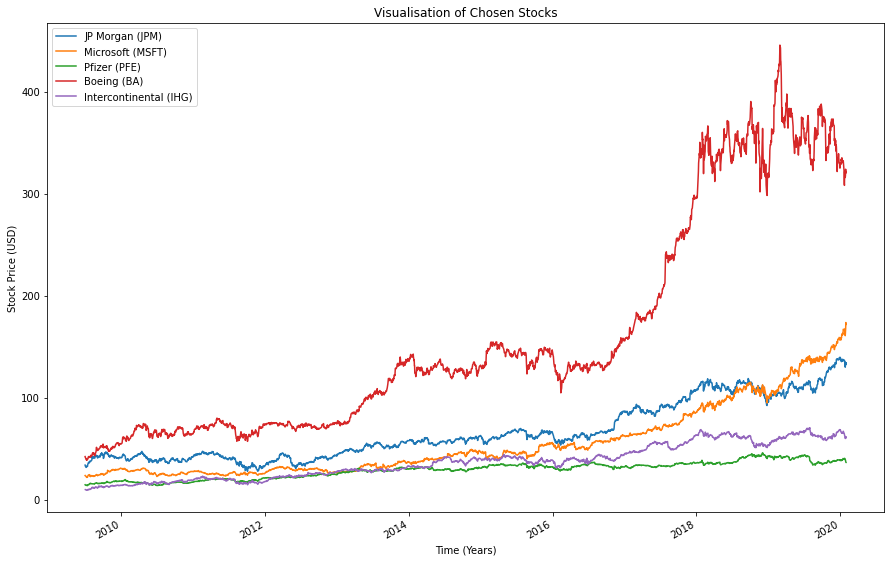

In [0]:
Intercontinental = intercontinental['open']
Boeing = boeing['open']
JPmorgan = jpmorgan['open']
Microsoft = microsoft['open']
Pfizer = pfizer['open']

plt.figure(figsize=(15,10))
JPmorgan.plot(label = 'JP Morgan (JPM)')
Microsoft.plot(label = 'Microsoft (MSFT)')
Pfizer.plot(label = 'Pfizer (PFE)')
Boeing.plot(label= 'Boeing (BA)')
Intercontinental.plot(label = 'Intercontinental (IHG)')
plt.title(label = 'Visualisation of Chosen Stocks')
plt.legend(loc='upper left')
plt.ylabel(ylabel= 'Stock Price (USD)')
plt.xlabel(xlabel= 'Time (Years)')
plt.savefig('stocks.png', bbox_inches ='tight')
files.download('stocks.png')
plt.show()

# **Vanilla GAN**

## **Creating the architecture**

In [0]:
def Generator_method(latent_space, num_outputs=2):  
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_space))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  return model

#latent_space = 10
#model = Generator(latent_space)
#model.summary()
#plot_model(model, to_file='generator_structure.png', show_shapes=True, show_layer_names=True)

In [0]:
def Discriminator_method(num_inputs=2): 
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(40, activation='relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#model = Discriminator()
#model.summary()
#plot_model(model, to_file='discriminator_structure.png', show_shapes=True, show_layer_names=True)

In [0]:
def GAN_method(Generator, Discriminator): 
  Discriminator_model.trainable = False
  model = Sequential()
  model.add(Generator_model)
  model.add(Discriminator_model)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

#latent_space = 10
#Generator_model = Generator(latent_space)
#Discriminator_model = Discriminator()

#model = GAN(Generator_model, Discriminator_model)
#model.summary()
#plot_model(model, to_file='gan_structure.png', show_shapes=True, show_layer_names=True)

In [0]:
def real_examples(n): 
  X_var = -2.5+(2.5-(-2.5))*rand(1,n)
  #X_var = np.arange(0, n*0.1,0.1)
  X_func = (X_var + 3)*((X_var -2)**2)*((X_var+1)**3)
  #X_func = np.sin(X_var)
  X_var = X_var.reshape(n,1)
  X_func = X_func.reshape(n,1)
  X = hstack((X_var,X_func))
  y = ones((n,1))
  return X,y

def latent_points(latent, n):
  input_var = randn(latent*n)
  input_var = input_var.reshape(n,latent)
  return input_var

def fake_examples(gen, latent,n):
  input_var = latent_points(latent, n)
  X = gen.predict(input_var)
  y = zeros((n,1))
  return X,y

In [0]:
def snapshot(epoch, gen, dis, latent, n=100):
  example_real, label_real = real_examples(n)
  _, real_accuracy = dis.evaluate(example_real, label_real, verbose=0)
  example_fake, label_fake = fake_examples(gen, latent, n)
  _, fake_accuracy = dis.evaluate(example_fake, label_fake, verbose=0)

  print("epoch: " , epoch +1, "accuracy detecting a fake: ", fake_accuracy, "accuracy detecting a real example: ", real_accuracy)
  plt.scatter(example_real[:,0], example_real[:,1], color='green', label='Real Distribution')
  plt.scatter(example_fake[:,0], example_fake[:,1], color='red', label='Generated')
  plt.legend(loc='upper left')
  plt.savefig("output.png")
  #files.download("output.png")
  plt.show()

In [0]:
def gen_method(latent, num_outputs=2):
  model = Sequential()
  model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_outputs, activation='linear'))
  return model

def dis_method(num_inputs=2):
  model = Sequential()
  model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=num_inputs))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def gan_method(gen, dis):
  dis.trainable =False
  model = Sequential()
  model.add(gen)
  model.add(dis)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [0]:
def training_method(gen_architecture, dis_architecture, gan_architecture, latent, epochs=35000, batch_size=256, snapshot_value=5000):
  update = int(batch_size/2)
  for i in range(epochs):
    example_real, label_real = real_examples(update)
    example_fake, label_fake = fake_examples(gen_architecture, latent, update)
    dis_architecture.train_on_batch(example_real, label_real)
    dis_architecture.train_on_batch(example_fake, label_fake)

    gan_input = latent_points(latent, batch_size)
    gan_labels = ones((batch_size,1))
    gan_architecture.train_on_batch(gan_input, gan_labels)
    if (i+1) % snapshot_value ==0:
      snapshot(i,gen_architecture,dis_architecture,latent)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:  5000 accuracy detecting a fake:  0.6700000166893005 accuracy detecting a real example:  0.6100000143051147


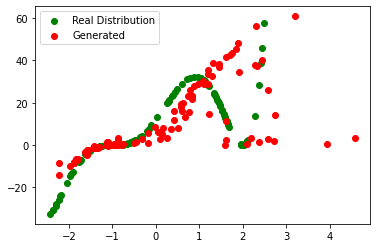

epoch:  10000 accuracy detecting a fake:  0.6299999952316284 accuracy detecting a real example:  0.46000000834465027


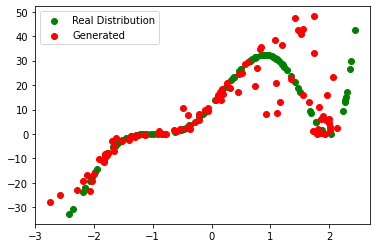

epoch:  15000 accuracy detecting a fake:  0.5899999737739563 accuracy detecting a real example:  0.699999988079071


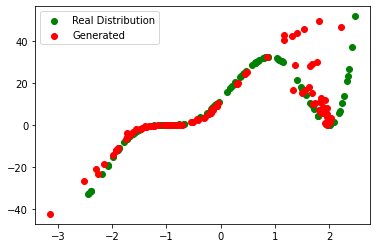

epoch:  20000 accuracy detecting a fake:  0.7099999785423279 accuracy detecting a real example:  0.7099999785423279


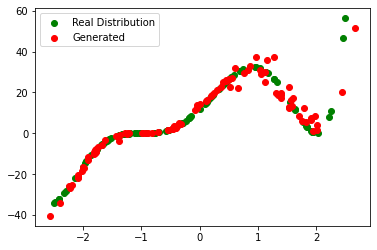

epoch:  25000 accuracy detecting a fake:  0.6100000143051147 accuracy detecting a real example:  0.6600000262260437


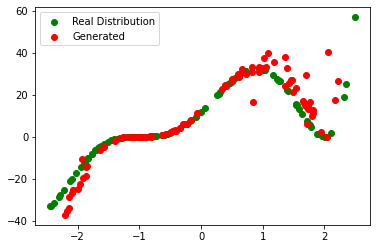

epoch:  30000 accuracy detecting a fake:  0.6399999856948853 accuracy detecting a real example:  0.47999998927116394


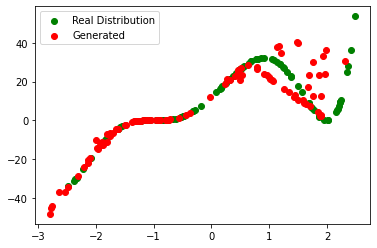

epoch:  35000 accuracy detecting a fake:  0.6299999952316284 accuracy detecting a real example:  0.6600000262260437


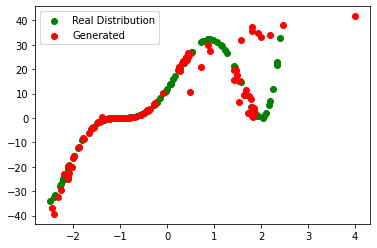

In [8]:
latent = 5
gen = gen_method(latent)
dis = dis_method()
gan_architecture = gan_method(gen,dis)

training_method(gen, dis, gan_architecture, latent)

# **Wasserstein GAN**

In [0]:
def wasserstein_loss():
  